<a href="https://colab.research.google.com/github/GDS-Education-Community-of-Practice/DSECOP/blob/connor_module/Time_Series_Analysis_and_Forecasting/N2_Time_Series_Analysis_and_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Notebook 2: Time series analysis of projectile data

In the previous notebook, we simulated the motion of several trapezoid shaped projectiles that collect information after having been catapulted from the ground.
This is an imagined scenario but takes the simple Newtonian motion of an idealized projectile and considers a more realistic scenario of varied drag.

This data includes a varied drag coefficient and projectile area for four sides of the object

A large number of these runs was simulated and saved in the file `launches.csv`.
We begin by loading this file of simulated launches.

In [2]:
# Load our launch data
data_location = "https://raw.githubusercontent.com/GDS-Education-Community-of-Practice/DSECOP/connor_module/Time_Series_Analysis_and_Forecasting/launches.csv"
all_launches = pd.read_csv(data_location, index_col="Time (s)")

# Split into individual launches
split_indices = np.where(all_launches.index[1:] - all_launches.index[0:-1] < 0)[0].tolist() # Find where time decreases (signifies different launch)
split_indices = [0] + split_indices + [all_launches.shape[0]]
launches = [all_launches.iloc[split_indices[i]+1:split_indices[i+1]] for i in range(100)]

For the sake of simplicity in our time series analysis, we can consider averaging all of the runs to examine the general behavior.

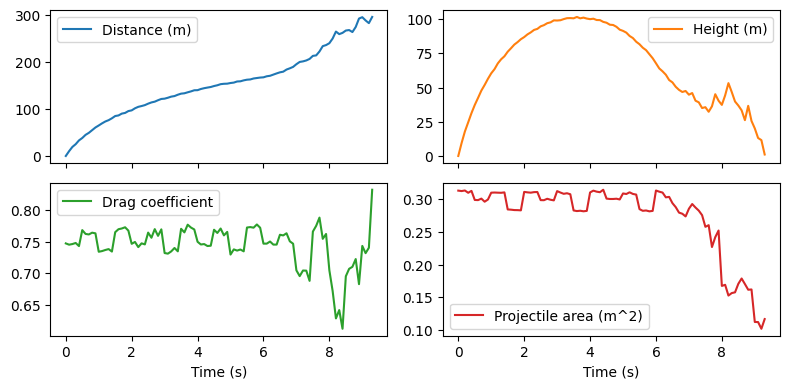

In [3]:
# Group by the time stamps and average
all_launches = all_launches.groupby(all_launches.index).mean()

all_launches.plot(subplots=True, layout=(2,2), figsize=(8,4))
plt.tight_layout()
plt.show()

Now, notice that there are some strange dips in the drag coefficient and area in later times. 
If we look closely at all of the launch data, we can note that some time series are longer than others, thus the averages in later times include 0s for some series.

Let's cut out series at the minimum end time for all the launches to try to resolve this issue.

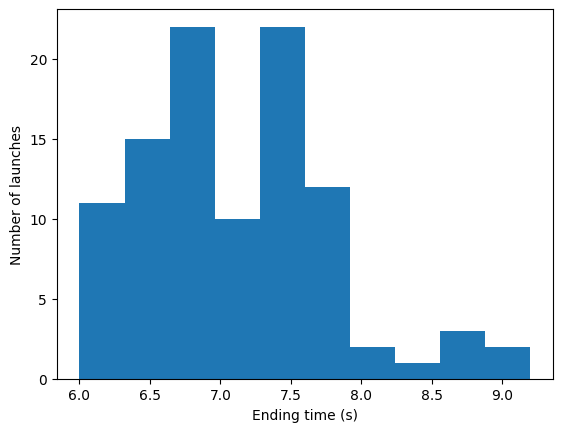

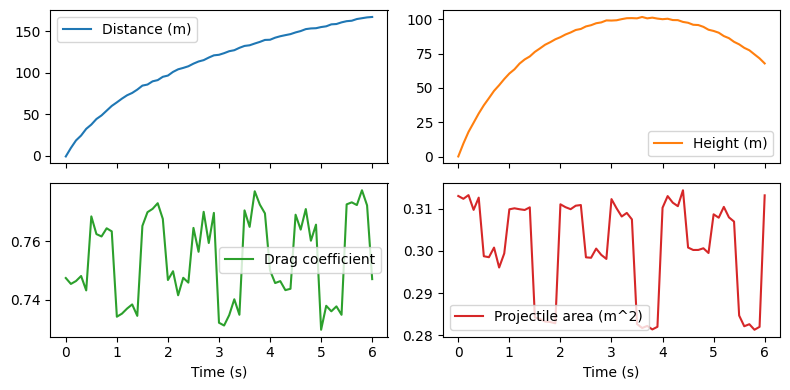

In [4]:
# End time for all launches
end_times = [launch.index.max() for launch in launches]

plt.close('all')
plt.hist(end_times)
plt.xlabel("Ending time (s)")
plt.ylabel("Number of launches")
plt.show()

# Shortest end time
shortest_end = np.min(end_times)

# Cut our launches
our_launches = all_launches.loc[:shortest_end]

our_launches.plot(subplots=True, layout=(2,2), figsize=(8,4))
plt.tight_layout()
plt.show()

We now have a much more consistent approximation of drag and area.

## General concepts for time series
Time series analysis is just the analysis of data that has been collected over a range of time.
However, due to its importance in fields such as weather, stock markets, geophysics, signal processing, and econometrics, it has developed a unique terminology and specific methods tailored to time dependent data.

### Basic concepts
Some of the basic ideas that are of interest in time series data are the following:
- **Trends:** Is there a general direction of the data?
- **Seasonality:** Is there a trend that repeats itself on a fixed schedule?
- **Cyclical component:** Is there a trend that repeats itself outside of a fixed schedule?
- **Irregular variation:** Are there unpredictable and erratic variations in the data?
- **Autocorrelation:** Are observations at a point in time usually similar to observations at a previous point of time (e.g. an observation at time $t$ is always similar to an observation at $t-1$)?


### Seasonality of data
With the above vocabulary in mind, it is common to consider an **ETS decomposition** of the data which is to separate the error, trend, and seasonality of the data.
There are two common formats for this separation:
1. **Multiplicative:** data = error $\times$ trend $\times$ seasonality
2. **Additive:** data = error $+$ trend $+$ seasonality

The python packages `statsmodels.tsa` contains many time series analysis tools, including some for this decomposition:

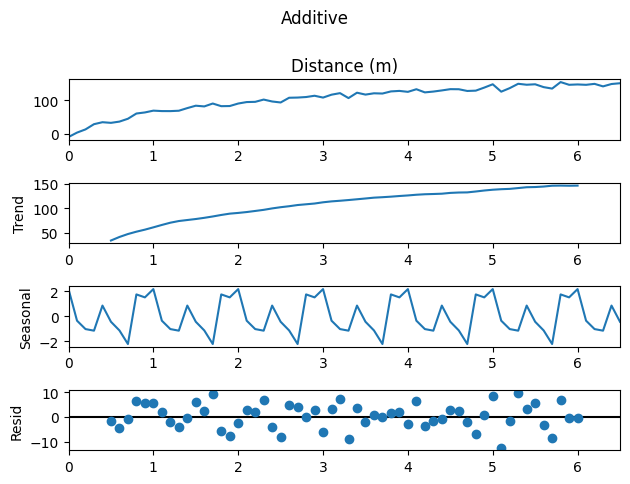

In [5]:
test_launch = launches[20]

# Separate error trend and seasonality in additive
plt.close('all')
seasonal_decompose(test_launch['Distance (m)'], model='additive',period=10).plot().suptitle("Additive",y=1)
plt.tight_layout()
plt.show()


Now, this decomposition was done for the distance data, which has a very obvious trend (distance increases with time).
The seasonality of the data is almost none existant (see the scale on the y-axis and just look at the data).
As a result, there may not be much of a use for this decomposition for this variable.

However, it may be better to consider a variable such as the drag coefficient (which we know has a set rotation and thus some seasonality).

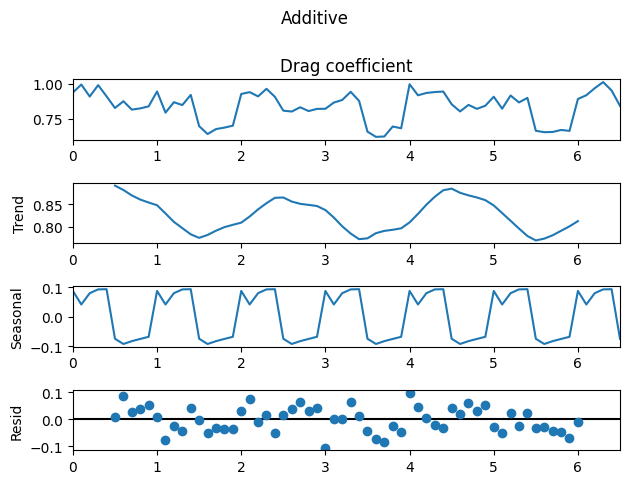

In [6]:
# Separate error trend and seasonality in additive form
plt.close('all')
seasonal_decompose(test_launch['Drag coefficient'], model='additive',period=10).plot().suptitle("Additive",y=1)
plt.tight_layout()
plt.show()

Note that we arent capturing well the seasonality, so we should adjust the `period` parameter (which represents the hypothesized length of the season in time points).

---- 
### Problem 1

Adjust the `period` parameter of the additive decomposition to capture the seasonality (i.e. the trend line is more flat and the seasonality curve looks like the peaks and valleys of the data).

In [7]:
# Answer to Problem 1

----
Now that we have captured the seasonality, the trend actually seems somewhat nonexistant - the drag coefficient isn't increasing or decreasing over time.
This is what we expect as we know that the object is rotating at a constant rate.

Let's consider the multiplicative decomposition as a comparison.

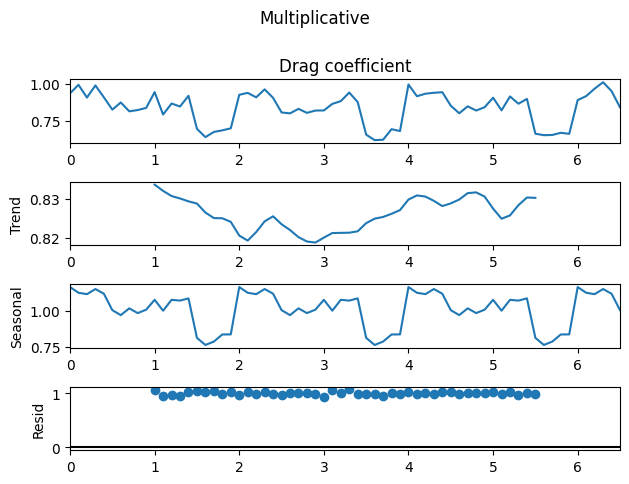

In [8]:
# Separate error trend and seasonality in multiplicative decomposition
plt.close('all')
seasonal_decompose(test_launch['Drag coefficient'], model='multiplicative',period=20).plot().suptitle("Multiplicative",y=1)
plt.tight_layout()
plt.show()

You can see that both decompositions are similar.
The main difference between them is the `resid` plot which represents the "residual error," or the error component of the decomposition.
Though the size of this error is not important for our current case, we don't want it to have any noticeable pattern, as this would indicate that it is not erratic and unpredictable.
For this reason, let's stick with the additive decomposition.

### Automatically determining seasonality

Now, although we just changed the `period` above until we found a good match, we could instead use a test for the seasonality of the data.
To do so, consider the "autocorrelation" or the relation of values at a certain point in time with values at fixed amounts of time before.

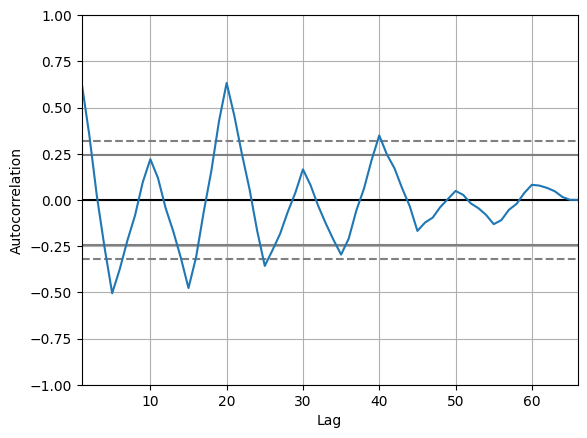

In [9]:
# Use pandas autocorrelation plot
plt.close('all')
pd.plotting.autocorrelation_plot(test_launch["Drag coefficient"])
plt.show()

In this plot, it shows the relationship between observations at a given point in time with those a certain amount of time before (lag). 
So, this plot tells us that the values seem to be positively correlated (similar) with those at specific points before (namely, 10, 20, 30, ... time points before).
This matches our results and makes sense in relation to the rotation of our object, which changes sides every 5 time points, thus arriving back at a side every 20!
The only reason this isn't perfectly apparent in the seasonality of the data is because of the added noise.

## Smoothing

Even after decomposing our data to see trends and seasonality, there is still some erratic error in the variables.
"Smoothing" out this erratic behavior in the data is a key strategy in time series analysis.


### Moving average
The most common approach to this is the "moving average" which considers the next observation as the mean of the previous $k$ points:
$$
y_{i} = \frac{1}{k}\sum_{j=1}^k y_{i-j}
$$
The `pandas` library has a convenient function `rolling` which can select a rolling window of $k$ that we can then average.

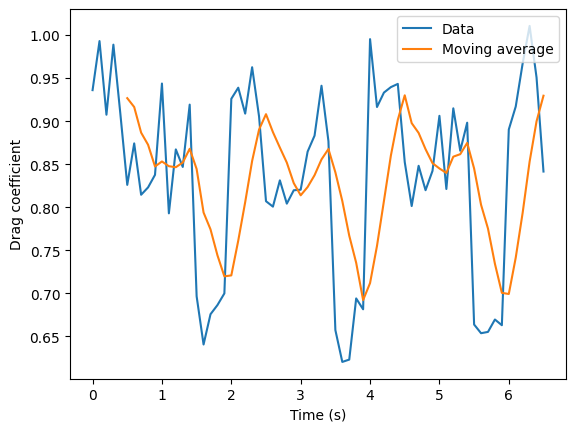

In [10]:
# Number of previous points to use in averaging
k = 6

# Plot
plt.close('all')
test_launch['Drag coefficient'].plot(label="Data")
test_launch['Drag coefficient'].rolling(k).mean().plot(label="Moving average")
plt.ylabel("Drag coefficient")
plt.legend()
plt.show()

Because the moving average is using $k$ points _BEFORE_ the point, we can see that it has shifted the peaks of our data slightly over in time.
Using only previous points can be necessary if we are looking to predict future values (which we will discuss in the next notebook), but as we are just analyzing previously collected data, we can add the `center=True` parameter to the rolling window collection to consider $k$ points _AROUND_ the point.

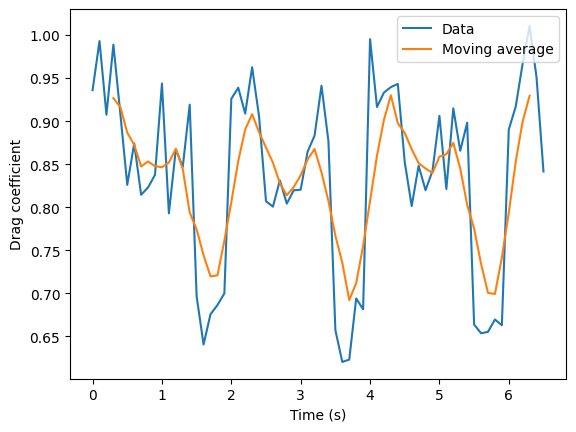

In [11]:
plt.close('all')
test_launch['Drag coefficient'].plot(label="Data")
test_launch['Drag coefficient'].rolling(k,center=True).mean().plot(label="Moving average")
plt.ylabel("Drag coefficient"); plt.legend()
plt.show()

This smoothing looks fairly reasonable.
But notice that each large peak in the data is followed by a smaller peak, which is entirely smoothed out by the moving average.
Maybe we could use a smoothing that can better keep these smaller features without sacrificing too much smoothing.

### Exponential smoothing
In the moving average smoothing, it is interesting that it takes an equally weighted average of all $k$ points previous.
It would maybe be more reasonable to consider that more recent occurences were more influential and should have more "weight" or consideration in choosing the next point.
This is the idea of "exponential smoothing."

For this, we weight the points by how recent they occurred:

$$
\hat{y}_i = \alpha y_i + (1-\alpha)\hat{y}_{i-1}
$$

The smaller the value of $0 \leq \alpha \leq 1$, the more previous points are included, i.e. the smoother the data.

Again, the `pandas` package has a function `ewm` that can provide exponentially weighted observations from our series.

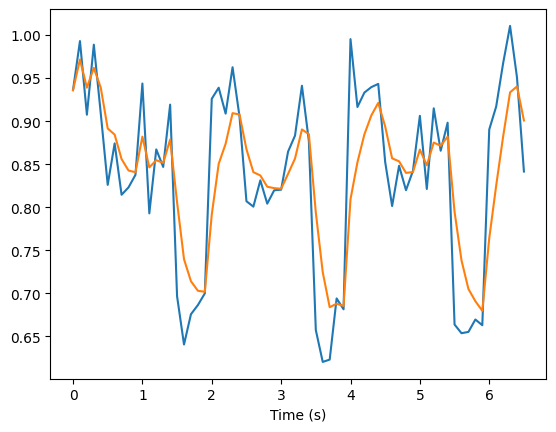

In [12]:
# Exponentially weight our data
alpha = .4

plt.close('all')
test_launch['Drag coefficient'].plot()
test_launch['Drag coefficient'].ewm(alpha=alpha).mean().plot()
plt.show()

Compared to the moving average, this method seems to keep some of the smaller features.
Notably, the smaller peak has survived the smoothing!

## Stationarity

The property of "stationarity" is very important in time series analysis and modeling.
A "stationary" series is one in which the mean and variance are constant and the series is time-invariant.
Let's go through each of these points individually.

### Constant mean

If the mean of the series is constant, it does not have a general trend.
Let's compare this in our series by looking at the mean of the distance over time and the drag coefficient.
To do so, assume we have $N$ points in time.
We look at the mean of our series $u$ through time by considering the sample means:

$$
\hat{\mu}_k = \frac{1}{k}\sum_{i=1}^k u
$$

where $1 \leq k \leq N$.
So, we are really looking at the average of all the subseries of length $k$ starting from the first point for our series of length $N$.

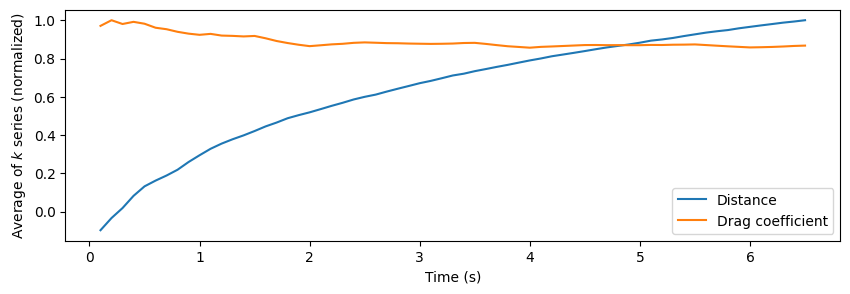

In [13]:
# Iterate the subseries length k
averages = []
for k in range(1,len(test_launch)):
    # Average all points up to time point k
    averages.append(test_launch.iloc[:k].mean())

# Plot the average over time for distance and drag coefficient
distance_means = [average['Distance (m)'] for average in averages]
drag_means = [average['Drag coefficient'] for average in averages]

plt.close('all')
fig = plt.figure(figsize=(10,3))
plt.plot(test_launch.index[1:], distance_means / np.max(distance_means), label="Distance")
plt.plot(test_launch.index[1:], drag_means / np.max(drag_means), label="Drag coefficient")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Average of $k$ series (normalized)")
plt.show()

In comparing these two plots, it is apparent that the drag coefficient is much more stationary than the distance.
This is very intuitive as the distance is an increasing quantity (the projectile just keeps going further) while the drag coefficient is periodic around some specific values.

Note that the avaerages were "normalized" (divided by the maximum average) in order to make them comparable in size to each other.

### Constant variance
If the variance of the series is constant, the size of the seasonal peaks are constant through time.
Let's compare this in our series by looking at the variance of the height and the area over time.
This would be to consider the sample variance $\bar{\sigma}$:

$$
\bar{\sigma}_k = \frac{1}{k}\sum_{i=2}^k (u - \hat{u}_k)
$$

for $2 \leq k \leq N$.

----
### Problem 2
Repeat the procedure used to compare the mean through time but use instead a calculation of the variance at each point and all previous points through time.

Discuss whether the results demonstrate stationarity of the data for the test launch.
Are either of the variance sequences

In [14]:
# Answer to Problem 2

Although the stationarity is not as clear in the variance (note for example that it takes some time for the area variance to level off), they both have some element of stationarity to them.
Of course the variance at the beginning is small for both because there are few sample points, but as time goes on, the seasonal peaks for both are quite stable.
The height is not actually seasonal, but according to the data, it increases and then returns to zero, so it could have a period the same length as the trajectory.

----
### Time-invariance
If the series is time-invariant, the seasonality of the series follows the same period through time.
This is not easily observable in our data, but would be easily so if, for example, our object increased or decreased its rotation throughout its trajectory (a very reasonable assumption).

Even so, let's compare again the period of seasonality over time for our distance and for our drag coefficient over time.

To do so, we will calculate the period of seasonality for the length $k$ subseries using the autocorrelation as was shown in [the section on automatically finding seasonality](#Automatically-determining-seasonality).
With this, we can determine the lag with the maximum autocorrelation and assume that is our period for the length $k$ subseries.

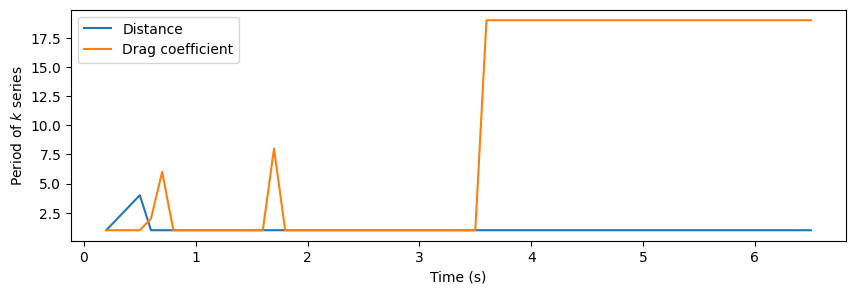

In [15]:
# Iterate the subseries length k
distance_periods = []
drag_periods = []
for k in range(2,len(test_launch)):
    # Find period for subseries time point k
    dist_autocorr = pd.plotting.autocorrelation_plot(test_launch['Distance (m)'].iloc[:k])
    distance_periods.append(dist_autocorr.get_lines()[-1].get_data()[1][1:].argmax()+1)
    drag_autocorr = pd.plotting.autocorrelation_plot(test_launch['Drag coefficient'].iloc[:k])
    drag_periods.append(drag_autocorr.get_lines()[-1].get_data()[1][1:].argmax()+1)
    
# Plot the periods over time for distance and drag coefficient
plt.close('all')
fig = plt.figure(figsize=(10,3))
plt.plot(test_launch.index[2:], distance_periods, label="Distance")
plt.plot(test_launch.index[2:], drag_periods, label="Drag coefficient")
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Period of $k$ series")
plt.show()

It is apparent that neither the distance or drag coefficient data is time invariant.
Both have the strongest autocorrelation with lag 1, which basically indicates no periodicity.
There are moments when the drag coefficient shows its periodicity, but that is not constantly visible for subseries of different lengths.

This is not too big of a problem, but is insightful.

### Why stationarity is good and how to get it

The key advantage to having a stationary system is that it allows for better forecasting of future events.
If the mean and variance are constant through time and the series is time-invariant, it basically means that the series is very consitent, making for easy prediction of the future.

As we've seen above, many series do not satisify this property.
However, it is common to manipulate the series to try to introduce some level of stationarity.

One simple way to try to enforce stationarity is to subtract a previous lag point that equals the seasonal period from each data point.
Let's consider our distance variable, which follows a very consistent trend upward.
If we take each point and subtract the previous point, we are now only looking at the amount of movement between each time point, which should be much more constant.

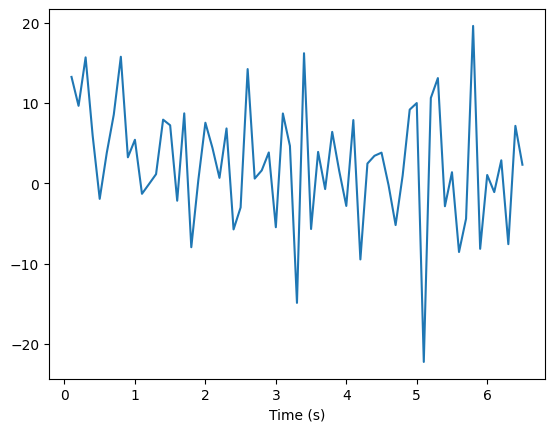

In [16]:
# Subtract the previous point from each point in our distance
stationary_distance = test_launch["Distance (m)"] - test_launch["Distance (m)"].shift()

plt.close('all')
stationary_distance.plot()
plt.show()

We can see that the series is now centered around 0 and has peaks and valleys of roughly the same height and period through time!
Great!

Let's try with a variable that has much more seasonality such as the area of our object.

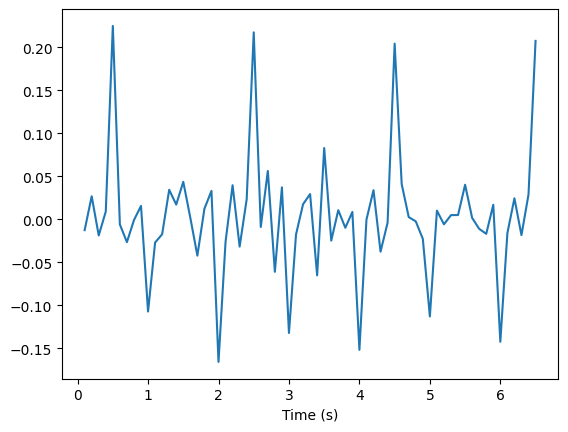

In [17]:
# Subtract the previous point from each point in our distance
stationary_area = test_launch["Projectile area (m^2)"] - test_launch["Projectile area (m^2)"].shift()

plt.close('all')
stationary_area.plot()
plt.show()

In this case, it seems that there are still some notable patterns for peaks throughout the series, i.e. still some seasonality in the data (notice there is a peak about every 2 seconds).
Remember from earlier that the period of the area and drag data is about 20 time steps.
Let's take the difference of our data with the point 20 time steps before to match our seasonality and see if that helps.

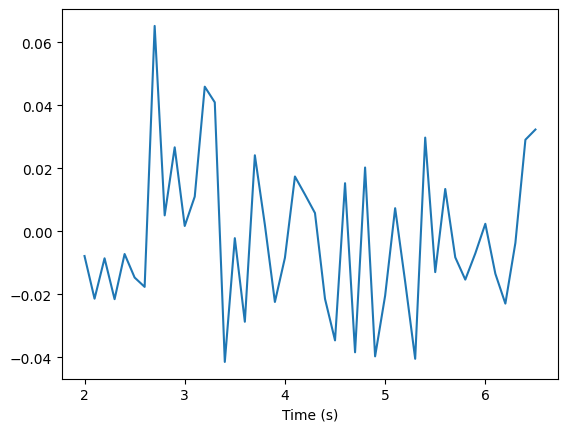

In [18]:
# Subtract the previous point from each point in our distance
stationary_area = test_launch["Projectile area (m^2)"] - test_launch["Projectile area (m^2)"].shift(periods=20)

plt.close('all')
stationary_area.plot()
plt.show()

This now looks much more stationary (no longer has any seasonality patterns or trends).

## Forecasting

A major topic in time series analysis is forecasting future data.
For example, if we work for a store that wants to make sure they are well stocked to meet demand for certain products, being able to predict how much of each product is needed in the future is very helpful.
In the context of physical systems, predicting future states of a system is the gold standard of good modeling and demonstrates that the most important phenomena have been captured.

### Autoregression

The general idea for time series forecasting is to try to take previous time points and somehow combine them to calculate future points.
Mathematically, this could be written simply as:
$$
u(t_{i}) = f(u(t_{i-1}),u(t_{i-2}),...)
$$
where $u(t_i)$ is our data at some time $t_i$ and $f$ is some function that combines all the previous data points.

If we were given stationary data (or almost stationary), it might be a reasonable assumption to just average the previous points since the average won't change over time.
However, the function $f$ is most commonly considered to be linear:
$$
u(t_i) = f = \sum_{j=1}^i b_j u(t_{j})
$$
where $b_j$ are "weights" for the data points.
This is intuitive to imagine.
Consider forecasting sales of a product in September.
Wouldn't the sales in August likely be more important than those in January?
With this in mind, we can give more "weight" to the August point than the January one.

This assumption gives rise to the first forecasting model we'll consider called an "autoregressive" or AR model.
It is written as 
$$
u(t_i) = f_{\text{AR}} = \epsilon_i + \sum_{j=1}^p b_j u(t_{i-j})
$$
where $\epsilon_i$ is some error term and $p$ determines how far back in time you want to consider.
Notice that the only variable to choose here is the lag $p$.

We can try this simple model using the Python `statsmodels.tsa` time series analysis package. 
For example, let's predict the second quarter of the distance variable in our test launch.
We choose the `lags` parameter as the number of points $p$ we would like to consider.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


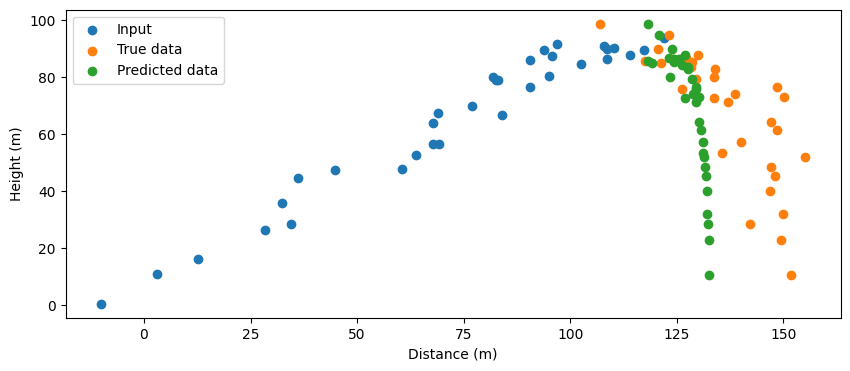

In [19]:
# Create the model
half_distance = test_launch["Distance (m)"].iloc[:33]
half_height = test_launch["Height (m)"].iloc[:33]
ar = AutoReg(half_distance, lags=5)

# Find the coefficients b_j
ar_fitted = ar.fit()

# Predict the next steps
predicted_distance = ar.predict(ar_fitted.params, start=len(half_distance), end=2*len(half_distance)-1)
data_distance = test_launch["Distance (m)"].iloc[33:]
data_height = test_launch["Height (m)"].iloc[33:]

# Plot the true distance and the predicted
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(half_distance, half_height, label="Input")
plt.scatter(data_distance, data_height, label="True data")
plt.scatter(predicted_distance, data_height, label="Predicted data")
plt.ylabel("Height (m)")
plt.xlabel("Distance (m)")
plt.legend()
plt.show()

In this, we inputted the first half of the distance data to find the linear weights or parameters $b_j$.
The prediction seems to give a reasonable trend, but drops more quickly than the actual data.

However, it was fortunate in this case that we were able to capture the downward trend at all.
Its possible that if we had used less data, the trend may have been even worse.

----
### Problem 3

Repeat the previous fitting and predicting using the `AutoReg` class using only the first quarter of the data.
Does it capture the downward trend of the data?

In [20]:
# Answer to Problem 3

Note that the trend is captured even worse. At a certain point, the forecast completely freezes (the distance doesn't increase).

----

### Moving average model

Another popular approach that takes a different perspective (based on stationarity) is to assume that future points will be the average with some added error.
This is called the "moving-average" or MA model (not to be confused with our earlier exploration of moving averages).
In this case, the error is considered to be a sum of previous errors so:
$$
u(t_i) = f_{\text{MA}} = \hat{u} + \epsilon_i + \sum_{j=1}^q a_j \epsilon_{i-j}
$$

### ARMA

Though both AR and MA models are reasonable and popular choices, the most common time series forecasting method is the ARMA method which combines both the AR and MA linear models.
It can thus be written as:
$$
u(t_i) = \epsilon_i + \sum_{j=1}^p a_j \epsilon_{i-j} + \sum_{j=1}^q b_j u(t_{i-j})
$$

The `statsmodels.tsa` package in Python has a convenient class for forecasting with an ARMA model via the `ARIMA` class.
ARIMA is a slight modification on ARMA that will be discussed momentarily.
First, below is an example implementing forecasting using ARMA.
The parameters are `ARIMA(p,d,q)` where `p` is the lag number for errors $\epsilon_j$ and `q` is the lag number for values $u(t_j)$.

The ARMA model usually assumes stationarity in the data. 
For this reason, we input our data after differencing to make it more stationary.
As a result, the predictions are the differences between the steps.
These need to be added up to predict the future state.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Lik

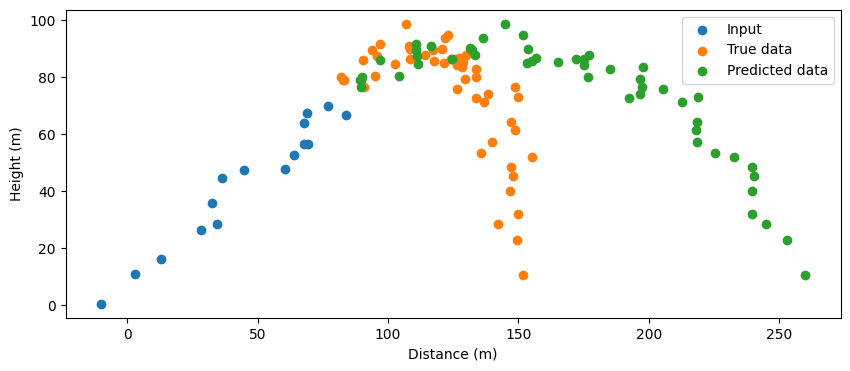

In [21]:
# Make our distance variable stationary before fitting the ARMA model
quarter_distance = test_launch["Distance (m)"].iloc[:16]
quarter_height = test_launch["Height (m)"].iloc[:16]
stationary_distance = quarter_distance - quarter_distance.shift()

# Fit the ARMA model
p = 5
d = 0
q = 5
arma = ARIMA(stationary_distance[1:], order=(p,d,q))
arma_fitted = arma.fit()

# Forecast future steps
predicted_distance = arma_fitted.forecast(steps=50)

# Take the cummulative sum of the predictions (differences) and add to the last training value
predicted_distance = np.cumsum(predicted_distance) + quarter_distance.iloc[-1]\

data_distance = test_launch["Distance (m)"].iloc[16:]
data_height = test_launch["Height (m)"].iloc[16:]

# Plot the predictions as compared to the true values
plt.close('all')
plt.figure(figsize=(10,4))
plt.scatter(quarter_distance, quarter_height, label="Input")
plt.scatter(data_distance, data_height, label="True data")
plt.scatter(predicted_distance, data_height, label="Predicted data")
plt.ylabel("Height (m)")
plt.xlabel("Distance (m)")
plt.legend()
plt.show()

The predicted data seems to follow the path of a projectile with no drag. However, it no longer freezes like we saw with the AR model!

### ARIMA

The ARMA model doesn't have a mechanism to adjust for trend or seasonality in the data.
A slight adjustment to the model that accounts for the trend is to adjust the moving average of the errors $\epsilon_j$.
This is called the autoregressive integrating moving average model or ARIMA.
It can be written as:
$$
u(t_i) = \epsilon_i + \sum_{j=1}^{p-d} a_j \epsilon_{i-j} + \sum_{j=1}^q b_j u(t_{i-j})
$$
where $d$ is an adjustment for the trend.

----

### Problem 4

Adjust the ARMA model example with alternate values of `d` to account for the increasing trend of our distance data.

Could you find a value that matches the future data better?

In [22]:
# Answer to Problem 4

----

With trend included, the forecasting is much more accurate!

## Appendix

**Resources:**
- https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python
- https://medium.com/open-machine-learning-course/open-machine-learning-course-topic-9-time-series-analysis-in-python-a270cb05e0b3
- https://towardsdatascience.com/the-complete-guide-to-time-series-analysis-and-forecasting-70d476bfe775